In [1]:
!pip install -U image-classifiers
!pip install -U efficientnet
!pip install gspread oauth2client
!pip install gspread oauth2client pytz tzlocal
!pip install pytz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 1.9 MB/s eta 0:00:00


In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
import requests
import pytz
from tzlocal import get_localzone  # for local timezone detection
from google.colab import auth
scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive",
    "https://www.googleapis.com/auth/userinfo.profile",
    "https://www.googleapis.com/auth/userinfo.email"
]

### Mount Drive
* change working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
creds = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/Research/credentials.json', scope)
client = gspread.authorize(creds)

In [5]:
cd /content/drive/MyDrive/Research/local

/content/drive/.shortcut-targets-by-id/1Pb3j-nq-wINa1YH-evYQ42iTfCy1tMmq/Research/local


In [ ]:
ls -la

total 19
drwx------ 2 root root 4096 Nov  5 04:31 coreLib/
-rw------- 1 root root 6148 Oct 31 15:48 .DS_Store
drwx------ 2 root root 4096 Nov  5 05:57 MODEL_DIR/
drwx------ 3 root root 4096 Nov  5 05:58 models/


# PARAMETERS
**BEFORE YOU START**

> Indented block


* **Kaggle dataset GCS path** from kaggle dataset
* **UPLOAD DATA CONFIG**

**SET THE FOLLOWING VARIABLES**
```python
  GCS_PATH    :    The raw path of kaggle gcs
  EPOCHS      :    number of epochs  
  BUFFER_SIZE :    shuffle size of the buffer    
  MODEL_NAME  :    name of the saved model
  TF_IDEN     :    name of the zipped folder
  DATA_FOLDER :    tfrecords folder
```

In [6]:
# DO NOT CHANGE THIS
# DO NOT CHANGE THIS

sheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1LQSsHwpJ14zvS1KdF_mDW39AQHQUr3tBI3acYxOF4A0/edit?usp=sharing").sheet1
auth.authenticate_user()
user_info = requests.get('http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/token', headers={"Metadata-Flavor": "Google"}).json()
access_token = user_info['access_token']
user_info = requests.get("https://www.googleapis.com/oauth2/v2/userinfo",
                         params={"access_token": access_token}).json()
user_email = user_info['email']
user_name = user_info.get('name')
if not user_name:
    user_name = user_email.split('@')[0].replace('.', ' ').title()

# DO NOT CHANGE THIS
# DO NOT CHANGE THIS

import os
GCS_PATH    =    'gs://kds-be7d0691e954df3457ce7220abc6cd3758f472fae588fe241aed2c3d'
MODEL_NAME  =    "xception" # @param ["vgg16","vgg19","resnet18","resnet34","resnet50","resnet101","resnet152","resnet50v2","resnet101v2","resnet152v2","resnext50","resnext101","densenet121","densenet169","densenet201","inceptionv3","xception","inceptionresnetv2","seresnet18","seresnet34","seresnet50","seresnet101","seresnet152","seresnext50","seresnext101","senet154","nasnetlarge","nasnetmobile","mobilenet","mobilenetv2"]
DATA_FOLDER =    "content/drive/MyDrive/Research/tfrecords"
EPOCHS      =    250   # @param
BUFFER_SIZE =    2048
MODEL_DIR =    os.path.join(os.getcwd(),"models",f'{MODEL_NAME}')

if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

WEIGHT_PATH=os.path.join(MODEL_DIR,f"{MODEL_NAME}.h5")
GCS_PATH    =    f'{GCS_PATH}/{DATA_FOLDER}'
print(GCS_PATH)
print(WEIGHT_PATH)



gs://kds-be7d0691e954df3457ce7220abc6cd3758f472fae588fe241aed2c3d/content/drive/MyDrive/Research/tfrecords
/content/drive/.shortcut-targets-by-id/1Pb3j-nq-wINa1YH-evYQ42iTfCy1tMmq/Research/local/models/xception/xception.h5


# Config Reading

In [7]:
location_info = requests.get("https://ipinfo.io").json()
location = location_info.get("loc", "Location not available")

import json
with open('config.json') as f:
  config = json.load(f)

IMAGE_TYPE =  config['image_type']
IMG_DIM    =  config['img_dim']
LABELS     =  config['labels']
NB_CHANNEL =  config['nb_channels']
NB_CLASSES =  config['nb_classes']
NB_TRAIN   =  config['nb_train_data']
NB_EVAL    =  config['nb_eval_data']

config

{'image_type': 'rgb',
 'img_dim': 256,
 'labels': ['algal leaf',
  'Anthracnose',
  'bird eye spot',
  'brown blight',
  'gray light',
  'healthy',
  'red leaf spot',
  'white spot'],
 'nb_channels': 3,
 'nb_classes': 8,
 'nb_eval_data': 2849,
 'nb_train_data': 7128}

# DEFAULT OPS: TPU TFrecords

## TPU initialize

In [9]:
import tensorflow as tf
import os
timezone = pytz.timezone("Etc/GMT-6")
timestamp = datetime.datetime.now(timezone).strftime("%Y-%m-%d %H:%M:%S")

print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.15.0
Running on TPU  


REPLICAS:  8


## Training Params

In [10]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = NB_TRAIN//BATCH_SIZE
EVAL_STEPS      = NB_EVAL//BATCH_SIZE
print(STEPS_PER_EPOCH,EVAL_STEPS)

55 22


## Data input function

In [11]:
def data_input_fn(mode):
    '''
      This Function generates data from gcs
    '''

    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature((),tf.string) ,
                    'label'  : tf.io.FixedLenFeature((),tf.int64)
        }
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=NB_CHANNEL)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(IMG_DIM,IMG_DIM,NB_CHANNEL))

        idx = tf.cast(parsed_example['label'], tf.int32)
        label=tf.one_hot(idx,NB_CLASSES,dtype=tf.float32)
        return image,label

    gcs_pattern=os.path.join(GCS_PATH,mode,'*.tfrecord')
    file_paths = tf.io.gfile.glob(gcs_pattern)
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


# Data Check

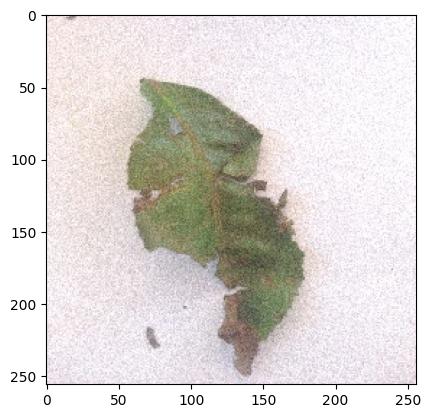

Image Batch Shape: (128, 256, 256, 3)
Target Batch Shape: (128, 8)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0.], shape=(8,), dtype=float32)
Data Successfully Done!


In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_ds  =   data_input_fn("train")
eval_ds   =   data_input_fn("eval")
test_ds  =   data_input_fn("test")

for x,y in eval_ds.take(1):
    data=np.squeeze(x[0])
    plt.imshow(data)
    plt.show()
    print('Image Batch Shape:',x.shape)
    print('Target Batch Shape:',y.shape)
    print(y[0])


sheet.append_row([timestamp, user_name, user_email, location])
print("Data Successfully Done!")

# MODEL definition
**THIS IS CHANGEABLE**

## Callbacks
**CHANGABLE**

In [13]:
# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-10)

mode_autosave = tf.keras.callbacks.ModelCheckpoint(WEIGHT_PATH,
                                                  save_best_only=True,
                                                  verbose=1,
                                                  period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  monitor='val_loss',
                                                  verbose=1,
                                                  mode = 'auto')

callbacks = [mode_autosave, lr_reducer,early_stopping ]

In [14]:
from classification_models.tfkeras import Classifiers
with strategy.scope():
    classifier, _ = Classifiers.get(MODEL_NAME)
    net=classifier(input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL),include_top=False)
    inp=net.input
    x=net.output
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.Dense(NB_CLASSES,activation="softmax")(x)
    model=tf.keras.Model(inputs=inp,outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [15]:
history = model.fit(train_ds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=eval_ds,
                    validation_steps=EVAL_STEPS,
                    callbacks=callbacks)

Epoch 1/250
55/55 [==============================] - ETA: 0s - loss: 0.9772 - accuracy: 0.6879
Epoch 1: val_loss improved from inf to 0.83565, saving model to /content/drive/.shortcut-targets-by-id/1Pb3j-nq-wINa1YH-evYQ42iTfCy1tMmq/Research/local/models/xception/xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 81s 559ms/step - loss: 0.9772 - accuracy: 0.6879 - val_loss: 0.8357 - val_accuracy: 0.6768 - lr: 1.0000e-04
Epoch 2/250
55/55 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9486
Epoch 2: val_loss improved from 0.83565 to 0.73233, saving model to /content/drive/.shortcut-targets-by-id/1Pb3j-nq-wINa1YH-evYQ42iTfCy1tMmq/Research/local/models/xception/xception.h5
55/55 [==============================] - 12s 212ms/step - loss: 0.1989 - accuracy: 0.9486 - val_loss: 0.7323 - val_accuracy: 0.7528 - lr: 1.0000e-04
Epoch 3/250
55/55 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9892
Epoch 3: val_loss did not improve from 0.73233
55/55 [==============================] - 10s 174ms/step - loss: 0.0538 - accuracy: 0.9892 - val_loss: 0.8184 - val_accuracy: 0.7610 - lr: 1.0000e-04
Epoch 4/250
55/55 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9956
Epoch 4: val_loss did not improve fro

## Model history

# Results



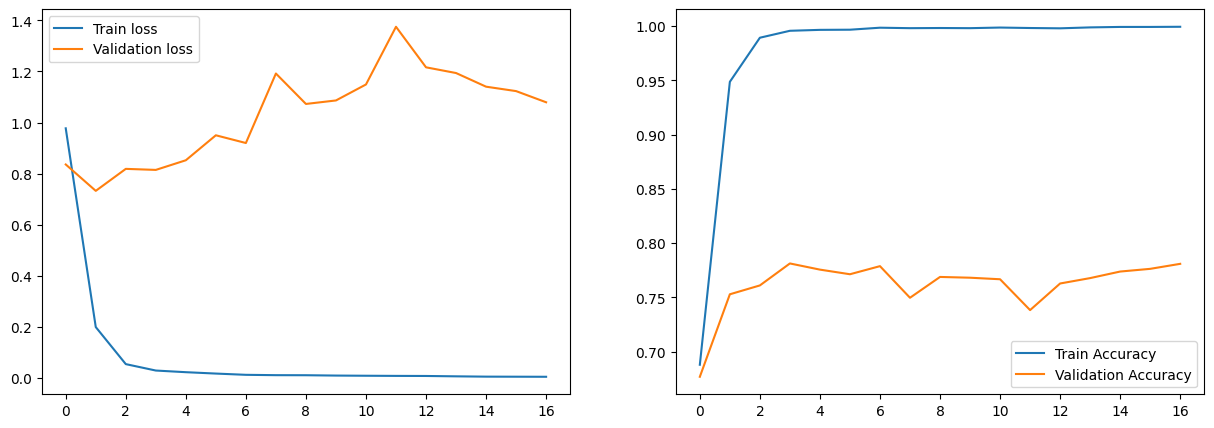

In [16]:
def plot_history(history,MODEL_DIR,iden):
    """
    Plots model training history
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
    ax_acc.legend()
    plt.savefig(os.path.join(MODEL_DIR,f"{iden}.png"))
    plt.show()

# show history
plot_history(history,MODEL_DIR,f"{MODEL_NAME}")

# Model Evaluation on pure testing

In [17]:
model.load_weights(WEIGHT_PATH)
result = model.evaluate(eval_ds,steps=EVAL_STEPS )
dict(zip(model.metrics_names, result))

22/22 [==============================] - 2s 43ms/step - loss: 0.7255 - accuracy: 0.7550


{'loss': 0.7255275249481201, 'accuracy': 0.7549715638160706}

In [18]:
from tqdm.auto import tqdm
gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

  0%|          | 0/22 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


In [19]:
from sklearn.metrics import classification_report
print(classification_report(gts, preds, target_names=LABELS))

               precision    recall  f1-score   support

   algal leaf       0.99      0.75      0.85       369
  Anthracnose       0.66      0.59      0.62       305
bird eye spot       0.56      0.78      0.65       261
 brown blight       0.55      0.94      0.69       365
   gray light       0.86      0.63      0.73       326
      healthy       0.95      0.99      0.97       251
red leaf spot       0.93      0.99      0.96       468
   white spot       0.73      0.43      0.54       471

     accuracy                           0.75      2816
    macro avg       0.78      0.76      0.75      2816
 weighted avg       0.79      0.75      0.75      2816



  0%|          | 0/22 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


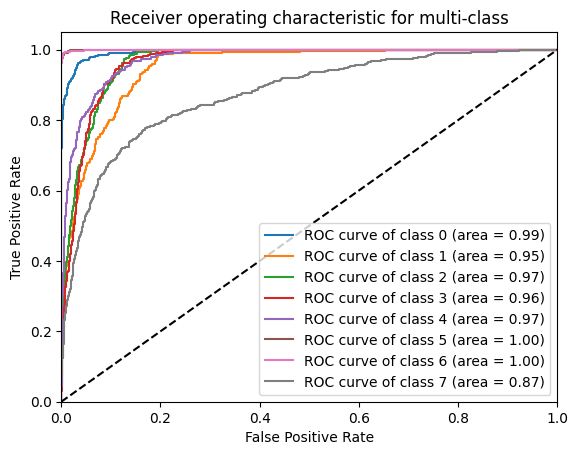

<Figure size 640x480 with 0 Axes>

In [20]:
from tqdm.auto import tqdm
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

gts=[]
preds=[]
probabilities = [] # Initialize probabilities list
images = []  # Store the image data

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred
  probabilities.append(y_pred) # Store the probabilities
  images.append(x.numpy()) # Store the image data

gts=np.array(gts)
preds=np.array(preds)
probabilities = np.concatenate(probabilities, axis=0) # Concatenate probabilities into a single array
images = np.concatenate(images, axis=0)  # Concatenate images into a single array

# Calculate ROC curve for each class
n_classes = probabilities.shape[1] # Get the number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(gts == i, probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()
plt.savefig( os.path.join(MODEL_DIR,f"roc_curve_1_{MODEL_NAME}.png"))

  0%|          | 0/22 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


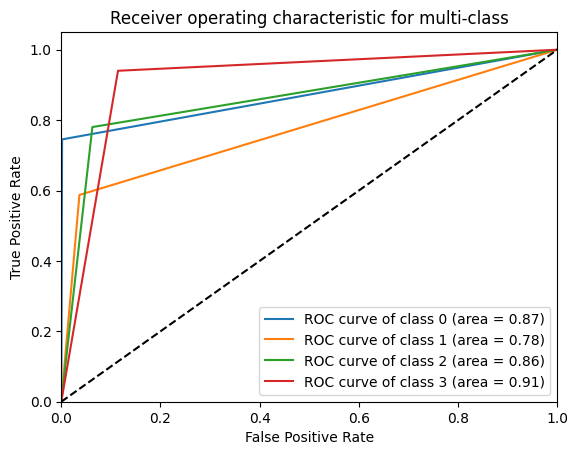

<Figure size 640x480 with 0 Axes>

In [21]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


gts=[]
preds=[]

for x,y in tqdm(eval_ds.take(EVAL_STEPS)):
  y_pred=model.predict(x)
  gt= list(np.argmax(y, axis=1))
  pred=list(np.argmax(y_pred, axis=1))
  gts+=gt
  preds+=pred

gts=np.array(gts)
preds=np.array(preds)

# Convert multiclass problem to binary by selecting one class vs the rest
n_classes = 4 # Example: Assuming you have 5 classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(gts == i, preds == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()
plt.figure( os.path.join(MODEL_DIR,f"ROC_{MODEL_NAME}.png"))
plt.savefig( os.path.join(MODEL_DIR,f"roc_curve_2_{MODEL_NAME}.png"))

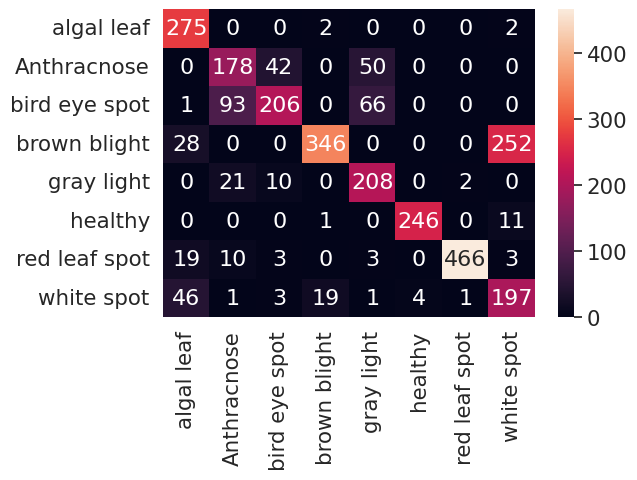

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
con_mat=confusion_matrix(preds, gts)
df_cm = pd.DataFrame(con_mat,
                     index = LABELS,
                     columns = LABELS)
plt.figure(figsize = (6,4))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
plt.savefig( os.path.join(MODEL_DIR,f"confusion_{MODEL_NAME}.png"))
plt.show()